In [ ]:
import json
import math
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pwd

'/content'

In [ ]:
import cv2
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def read_in_rgb(imagename):
  return np.asarray(Image.open(imagename).convert("RGB"))

def Loading_Data_from(DIR, SIZE=224):
    IMG = []
    #tqdm used for showing in the format of progress loader
    
    for u in tqdm(os.listdir(DIR)):
        filetype=os.listdir(DIR)[0][-4:]
        Path_of_Image = os.path.join(DIR,u)
        if filetype == ".jpg":
            image = read_in_rgb(Path_of_Image)
           
            image = cv2.resize(image, (SIZE,SIZE))
           
            IMG.append(np.array(image))
    return IMG

b_train = np.array(Loading_Data_from('/content/drive/MyDrive/Dataset/archive (1)/train/benign'))
m_train = np.array(Loading_Data_from('/content/drive/MyDrive/Dataset/archive (1)/train/malignant'))
b_test = np.array(Loading_Data_from('/content/drive/MyDrive/Dataset/archive (1)/test/benign'))
m_test = np.array(Loading_Data_from('/content/drive/MyDrive/Dataset/archive (1)/test/malignant'))

100%|██████████| 300/300 [00:06<00:00, 46.73it/s]


In [ ]:
import keras
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical
def return_labelled_data(x,y):
  return np.concatenate((x, y), axis = 0)

b_train_label = np.zeros(len(b_train))
m_train_label = np.ones(len(m_train))
b_test_label = np.zeros(len(b_test))
m_test_label = np.ones(len(m_test))

X_train = return_labelled_data(b_train, m_train)
Y_train = return_labelled_data(b_train_label, m_train_label)
X_test = return_labelled_data(b_test, m_test)
Y_test = return_labelled_data(b_test_label, m_test_label)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

Lets look at some of the dataset images


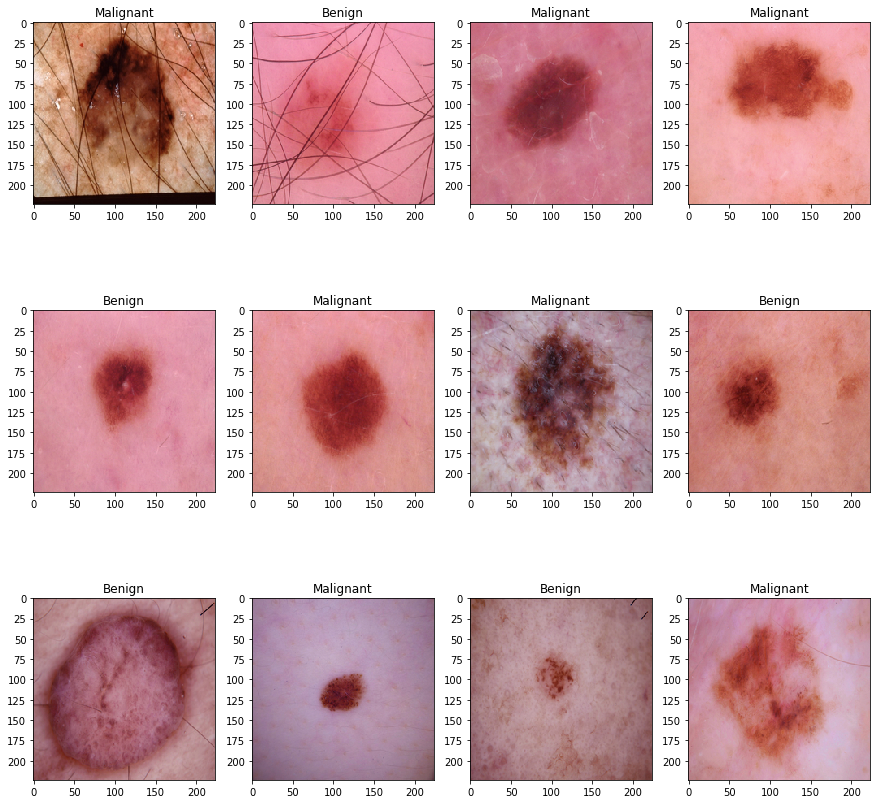

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15))

print("Lets look at some of the dataset images")
for i in range(1, 12 +1):
    axisi = fig.add_subplot(3, 4, i)
    if np.argmax(Y_train[i]) == 0:
        axisi.title.set_text('Benign')
    else:
        axisi.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
from keras import layers
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam



def building_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = building_model(resnet ,lr = 1e-4)

74850304/74836368 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="vgg16_1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/5
131/131 [==============================] - 3021s 23s/step - loss: 0.4895 - accuracy: 0.7781 - val_loss: 0.3324 - val_accuracy: 0.8390 - lr: 1.0000e-04
Epoch 2/5
131/131 [==============================] - 2961s 22s/step - loss: 0.4119 - accuracy: 0.8203 - val_loss: 0.3960 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 3/5
131/131 [==============================] - 2926s 22s/step - loss: 0.3988 - accuracy: 0.8255 - val_loss: 0.4211 - val_accuracy: 0.8352 - lr: 1.0000e-04
Epoch 4/5
131/131 [==============================] - 2951s 22s/step - loss: 0.3521 - accuracy: 0.8412 - val_loss: 0.3647 - val_accuracy: 0.8504 - lr: 1.0000e-04
Epoch 5/5
131/131 [==============================] - 2932s 22s/step - loss: 0.3494 - accuracy: 0.8440 - val_loss: 0.2571 - val_accuracy: 0.8902 - lr: 1.0000e-04


In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [ ]:
Y_val_pred = model.predict(x_val)

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8901515151515151

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
tta_steps = 4
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
100%|██████████| 4/4 [11:33<00:00, 173.30s/it]


Confusion matrix, without normalization
[[328  32]
 [ 58 242]]


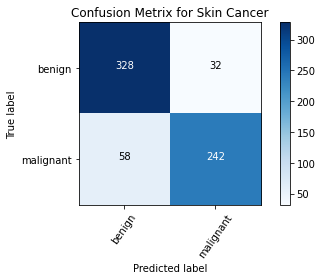

In [ ]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cmat, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cmat.Blues):
    
    if normalize:
        cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cmat)

    plt.imshow(cmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    threshold = cmat.max() / 2.
    for element1, element2 in itertools.product(range(cmat.shape[0]), range(cmat.shape[1])):
        plt.text(element2, element1, format(cm[element1, element2], fmt),
                 horizontalalignment="center",
                 color="white" if cmat[element1, element2] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cmat = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cmat, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.91      0.86      0.88       360\n           1       0.84      0.90      0.87       300\n\n    accuracy                           0.88       660\n   macro avg       0.88      0.88      0.88       660\nweighted avg       0.88      0.88      0.88       660\n'

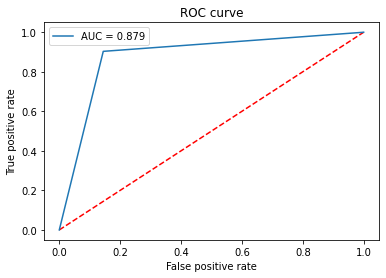

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

roc_analysis = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
auc_analysis = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(auc_analysis))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

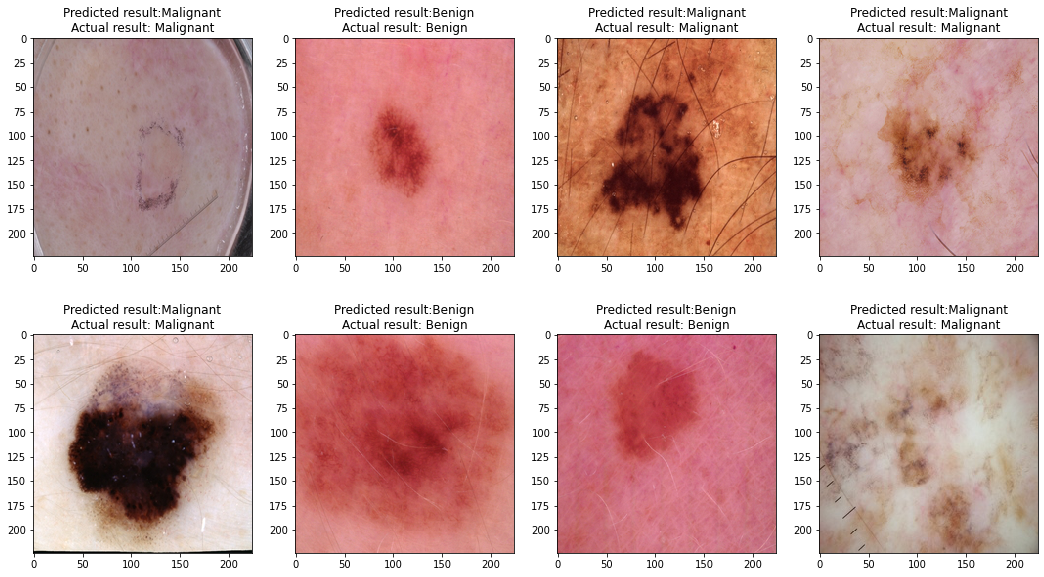

In [ ]:
i=0
prop_class=[]
mis_class=[]


for element in range(len(Y_test)):
    if(np.argmax(Y_test[element])==np.argmax(Y_prediction_tta[element])):
        prop_class.append(element)
    if(len(prop_class)==8):
        break

i=0
for num in range(len(Y_test)):
    if(not np.argmax(Y_test[num])==np.argmax(Y_prediction_tta[num])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# Display first 8 images of benign
w=100
h=60
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 4

def Transfername(predict):
    if predict==0:
        return "Benign"
    else:
        return "Malignant"
    
for num in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, num+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_prediction_tta[prop_class[num]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[num]])))
    plt.imshow(X_test[prop_class[num]], interpolation='nearest')
plt.show()

In [ ]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets
